## Fine-tune PaliGemma with JAX

<table class="tfo-notebook-buttons" align="left">
<td>
<a target="_blank" href="https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
</td>
<td>
<a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/fine-tuning-paligemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
<a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/fine-tuning-paligemma.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</table>


## Requirements
 1. 
To run this notebook, you will need to install the following dependencies:

`Python==3.11`

```bash
pip install python-dotenv kagglehub transformers gdown jax[cuda12] pillow ipykernel ipywidgets tensorflow ml-dtypes flax tqdm orbax-checkpoint matplotlib scikit-learn nltk rouge-score -U
```

2. 
Also, move `data/food-ingredients-101`, `data/food-101` & `data/ingredients-101` to root dir.

If `data/food-ingredients-101` is not present, create it using `merging_food101_ingredients101.ipynb`

3.
Install gsutil https://cloud.google.com/storage/docs/gsutil_install?hl=de#linux

### Set environment variables

Set the environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [1]:
import os

print(os.getenv('KAGGLE_USERNAME'))

simonbenedict


In [2]:
# set cuda to only recognize gpu 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

# for running on colab
# from google.colab import userdata
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# for running on local
from dotenv import load_dotenv
load_dotenv()
os.environ["KAGGLE_USERNAME"] = os.getenv('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = os.getenv('KAGGLE_KEY')

print(os.getenv('KAGGLE_USERNAME'))

simonbenedict


In [4]:
# for linux
!export KAGGLE_USERNAME
!export KAGGLE_KEY

### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

In [5]:
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [6]:
import base64
import functools
import html
import io
import os
import warnings
import random

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# === Additional imports ===
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import accuracy_score, precision_score, recall_score
from rouge_score import rouge_scorer
from tqdm import tqdm

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

2024-07-23 23:25:52.256057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 23:25:52.319546: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 23:25:52.337015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 23:25:53.222432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_3866/1877585094.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


JAX version:  0.4.30
JAX platform: gpu
JAX devices:  1


I0000 00:00:1721769954.596303    3866 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-23 23:25:54.757780: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

### Download the model checkpoint

PaliGemma includes several model variations. For this tutorial, you'll use the base [JAX/FLAX PaliGemma 3B weight model](https://www.kaggle.com/models/google/paligemma/jax/paligemma-3b-pt-224).

Download the `float16` version of the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [7]:
import os
import kagglehub

# from google.colab import auth
# auth.authenticate_user()

In [8]:
MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
# or download from https://huggingface.co/google/paligemma-3b-pt-224/tree/main
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

Model path: /home/simon/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz


In [9]:
DATA_DIR_old="./longcap100"
if not os.path.exists(DATA_DIR_old):
  print("Downloading the dataset...")
  !gsutil -m -q cp -n -r gs://longcap100/ .
  print(f"Data path: {DATA_DIR_old}")

FOOD_DATA_DIR="./food-101"
if not os.path.exists(FOOD_DATA_DIR):
  print("Downloading the dataset...")
  !kaggle datasets download -d kmader/food41
  !unzip -q food41.zip -d ./food-101
  print(f"Data path: {FOOD_DATA_DIR}")

import os
import gdown

INGREDIENTS_DATA_DIR = "./ingredients-101"
if not os.path.exists(INGREDIENTS_DATA_DIR):
    os.makedirs(INGREDIENTS_DATA_DIR)  # Ensure the target directory exists
    print("Downloading the dataset...")
    # Define the URL of the Google Drive file
    url = 'https://drive.google.com/uc?id=14ztu2gjdowZdMdCvo1tAZJ0aK5rMs4kb'
    # Define the output file path
    output = 'Ingredients101.zip'
    # Download the file
    gdown.download(url, output, quiet=False)
    # Unzip only the contents of the "Ingredients101" directory directly into the target directory
    os.system(f'unzip -q {output} "Ingredients101/*" -d {INGREDIENTS_DATA_DIR}')
    # Move contents up from the nested "Ingredients101" directory and remove it
    nested_dir = os.path.join(INGREDIENTS_DATA_DIR, 'Ingredients101')
    for filename in os.listdir(nested_dir):
        os.rename(os.path.join(nested_dir, filename), os.path.join(INGREDIENTS_DATA_DIR, filename))
    os.rmdir(nested_dir)
    # Clean up the zip file after extraction
    os.remove(output)
    print(f"Data path: {INGREDIENTS_DATA_DIR}")

### Configure the model

It's time to actually start configuring the model that you're going to use.

For this notebook, you need to be able to fit your model onto a T4 GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be *frozen* when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the `model_config` as a [`FrozenConfigDict`](https://github.com/google/ml_collections/tree/master#frozenconfigdict) so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma `Model` class using the `model_config` as its configurations
* Load the model parameters into RAM
* Define a `decode` function to sample outputs from the model

This code in this cell takes about a minute to run to completion.

In [10]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as `float16`, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [11]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

# print(" == Model params == ")
# parameter_overview(params)

2024-07-23 23:26:24.470006: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.


In [12]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)
    mask_loss = [0] * len(tokens)

    if suffix:
        suffix_tokens = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix_tokens
        mask_ar += [1] * len(suffix_tokens)
        mask_loss += [1] * len(suffix_tokens)

    mask_input = [1] * len(tokens)
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once
    *   This allows you to do some data pre-processing before use
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results

In [13]:
# HERE

In [14]:
DATA_DIR = './food-ingredients-101'

In [15]:
import os
import json

# def merge_data(food_data_dir, ingredients_data_dir, data_dir):
#     # Create the data directory if it doesn't exist
#     os.makedirs(data_dir, exist_ok=True)

#     # Define the paths to the required files
#     food_train_file = os.path.join(food_data_dir, 'meta', 'train.json')
#     food_test_file = os.path.join(food_data_dir, 'meta', 'test.json')
#     ingredients_train_images = os.path.join(ingredients_data_dir, 'Annotations', 'train_images.txt')
#     ingredients_train_labels = os.path.join(ingredients_data_dir, 'Annotations', 'train_labels.txt')
#     ingredients_test_images = os.path.join(ingredients_data_dir, 'Annotations', 'test_images.txt')
#     ingredients_test_labels = os.path.join(ingredients_data_dir, 'Annotations', 'test_labels.txt')
#     ingredients_file = os.path.join(ingredients_data_dir, 'Annotations', 'ingredients.txt')

#     # Load the ingredients data
#     with open(ingredients_file, 'r') as f:
#         ingredients_list = [line.strip() for line in f.readlines()]

#     # Create a dictionary to map each class to its ingredients
#     class_to_ingredients = {i: ingredients for i, ingredients in enumerate(ingredients_list)}

#     def create_jsonl(image_file, label_file, split):
#         with open(image_file, 'r') as f:
#             image_paths = [line.strip() for line in f.readlines()]

#         with open(label_file, 'r') as f:
#             labels = [int(line.strip()) for line in f.readlines()]

#         if len(image_paths) != len(labels):
#             raise ValueError("The number of images and labels do not match.")

#         output_file = os.path.join(data_dir, f'{split}.jsonl')
#         with open(output_file, 'w') as f_out:
#             for image_path, label in zip(image_paths, labels):
#                 ingredients = class_to_ingredients[label]
#                 suffix = ', '.join(ingredients.split(','))
#                 record = {
#                     "prefix": "",
#                     "suffix": suffix,
#                     "image": food_data_dir + '/images/' + image_path + '.jpg',
#                 }
#                 f_out.write(json.dumps(record) + '\n')

#     # Process the train and test splits
#     create_jsonl(ingredients_train_images, ingredients_train_labels, 'train')
#     create_jsonl(ingredients_test_images, ingredients_test_labels, 'test')

# # Example usage
# merge_data('food-101', 'ingredients-101', 'food-ingredients-101')

In [16]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "train.jsonl"),
    # fopen_keys={"image": FOOD_DATA_DIR}
    )

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "val.jsonl"),
    # fopen_keys={"image": FOOD_DATA_DIR}
    )

test_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "test.jsonl"),
    # fopen_keys={"image": FOOD_DATA_DIR}
    )


from PIL import Image
import os
import io

def train_data_iterator():
    """Never ending iterator over training examples."""
    dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
    for example in dataset.as_numpy_iterator():
        try:
            # Decode the byte path to a string and form the full image path
            image_path = example["image"].decode()
            image = Image.open(image_path)
            image = preprocess_image(image)
        except Exception as e:
            # print(f"Error opening image at {image_path}: {e}")
            continue

        prefix = "caption en"
        suffix = example["suffix"].decode().lower()
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_loss": np.asarray(mask_loss),
            # "image_path": image_path,
        }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    try:
        image_path = example["image"].decode()
        image = Image.open(image_path)
        image = preprocess_image(image)
    except Exception as e:
        continue

    prefix = "caption en"
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


def test_data_iterator():
  """Single iterator over test examples."""
  for example in test_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    try:
        image_path = example["image"].decode()
        image = Image.open(image_path)
        image = preprocess_image(image)
    except Exception as e:
        continue

    prefix = "caption en"
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }

### View training examples

In this notebook, the training data contains 90 images that are paired with long descriptions of what's depicted in the image.

**Note:** Normal training data sets that are meant to be used for practical use cases should contain more images, but this notebook limits the number of data points so that you can train the model in a reasonable amount of time for an example.

The code below prints a random selection of images with their descriptions from the training data set so that you can see what the images and descriptions your model is trained on looks like. Each image is displayed in as a 128x128 pixel JPEG, with the description printed next to the image to the right.

Training examples



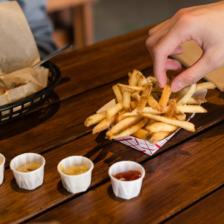
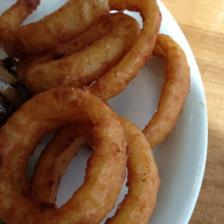
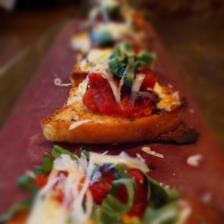
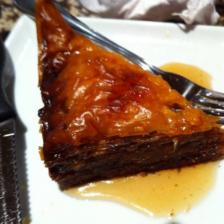
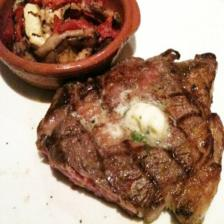
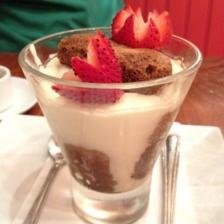
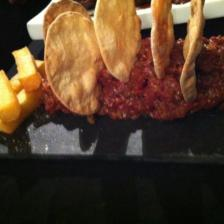
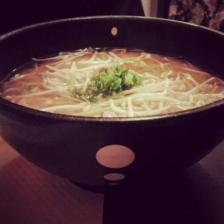

In [17]:
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"])  # detokenize model input.
  caption = caption[len("caption en\n"):]        # strip prefix
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

### Define the training and evaluation loops

Define the training loop to train the model on the provided dataset, and the evaluation loop to look at all of the examples in the validation dataset and make its predictions.

#### Defining the training loop

The `update_fn` function defines the training step. During the training step, the loss per example is calculated and stochastic gradient descent (SGD) is applied to the trainable parameters.

Recall that earlier in the notebook, you included flags in the `preprocess_tokens` function that included `mask_loss`. You'll use the `mask_loss` flag here to exclude prefix and padded tokens from the loss. Without it, the loss calculation will be skewed. You also need to normalize each example, since each of them has a different number of tokens. After the prefix and padded tokens have been excluded and the examples have been normalized, you can calculate the loss per example.

The training step also includes a function to apply an SGD to optimize the training.

#### Defining the evaluation loop

The `make_predictions` function is your evaluation loop. The evaluation loop is fairly straight forward with one notable change. If you recall from the beginning of the notebook, you only have 90 examples in your training data set. This is a very small amount of training examples, and your model ends up not having enough examples for the batch size when you run the training. This means that in the evaluation loop, you need to pad the batch by repeating examples.

To make sure that your evaluation loop only counts actual examples and not the padded examples, you have to apply a mask to the padded examples that excludes them from the output.

In [18]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

## Tune the model

Now that you've set everything up and taken a look at the training data, it's time to finally tune the model. The code below runs the training loop for the model for 64 steps and prints the learning rate (`lr` in the printed output) and loss rate for each step.

Every 16 steps, the model prints what its predictions are at that step in the training. This code prints out predictions for the same set of images so that you can see the model's ability to predict descriptions improve over time.

At earlier steps in the training, there's likely issues with the descriptions, such as repeated sentences as the model gets stuck in its predictive loop or unfinished sentences. The model's predictions become steadily more accurate as training progresses. By step 64, the model's predictions should closely resemble the descriptions provided by the training data.

This process takes around 15 minutes to complete on T4 TPUs.

In [19]:
# checkpointing setup

ckpt_dir = '/home/simon/Projects/MA/checkpoints'

# ==== With Orbax ====
from flax.training import orbax_utils
import orbax.checkpoint

# Initialize the PyTree Checkpointer
pytree_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

# Define checkpoint manager options
options = orbax.checkpoint.CheckpointManagerOptions(
    max_to_keep=3,  # Keep only the newest 3 checkpoints
    create=True
)

# Create the checkpoint manager
checkpoint_manager = orbax.checkpoint.CheckpointManager(
    ckpt_dir, pytree_checkpointer, options
)

In [23]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer


def batch_val_score_iterator(batch_size=4, num_examples=None, seed=42):
    random.seed(seed)
    
    all_examples = []
    class_examples = {}
    
    for example in val_dataset.get_tfdata().as_numpy_iterator():
        try:
            image_path = example["image"].decode()
            image_class = image_path.split('/images/')[1].split('/')[0]
            
            image = Image.open(image_path)
            image = preprocess_image(image)
            
            prefix = "caption en"
            suffix = example["suffix"].decode().lower()
            tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
            
            processed_example = {
                "image": np.asarray(image),
                "text": np.asarray(tokens),
                "mask_ar": np.asarray(mask_ar),
                "mask_input": np.asarray(mask_input),
                "suffix": suffix,
                "class": image_class,
                "image_path": image_path
            }
            
            all_examples.append(processed_example)
            
            if image_class not in class_examples:
                class_examples[image_class] = []
            class_examples[image_class].append(processed_example)
            
        except Exception as e:
            print(f"Error processing image: {e}")
            continue
    
    if num_examples is None:
        num_examples = len(all_examples)
    
    # Ensure at least one example from each class
    selected_examples = []
    for examples in class_examples.values():
        if examples:
            selected_examples.append(random.choice(examples))
    
    # Distribute remaining examples while maintaining class balance
    remaining_slots = num_examples - len(selected_examples)
    selected_image_paths = set(ex['image_path'] for ex in selected_examples)
    
    while remaining_slots > 0:
        for class_name, examples in class_examples.items():
            if remaining_slots > 0:
                remaining_class_examples = [ex for ex in examples if ex['image_path'] not in selected_image_paths]
                if remaining_class_examples:
                    selected_example = random.choice(remaining_class_examples)
                    selected_examples.append(selected_example)
                    selected_image_paths.add(selected_example['image_path'])
                    remaining_slots -= 1
            if remaining_slots == 0:
                break
    
    random.shuffle(selected_examples)
    
    # Yield batches
    for i in range(0, len(selected_examples), batch_size):
        yield selected_examples[i:i+batch_size]

def batch_test_score_iterator(batch_size=4, ordered=False):
    examples = []
    for example in test_dataset.get_tfdata(ordered=ordered).as_numpy_iterator():
        try:
            image_path = example["image"].decode()
            image = Image.open(image_path)
            image = preprocess_image(image)
            
            prefix = "caption en"
            suffix = example["suffix"].decode().lower()
            tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
            
            examples.append({
                "image": np.asarray(image),
                "text": np.asarray(tokens),
                "mask_ar": np.asarray(mask_ar),
                "mask_input": np.asarray(mask_input),
                "suffix": suffix,
            })
            
            if len(examples) == batch_size:
                yield examples
                examples = []
        except Exception as e:
            print(f"Error processing image: {e}")
            continue
    
    if examples:  # Yield any remaining examples
        yield examples
            

def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return (scores['rouge1'].fmeasure + scores['rouge2'].fmeasure + scores['rougeL'].fmeasure) / 3

# "f1 original"
def ingredient_overlap_f1_score(reference, candidate):
    ref_ingredients = set(reference.lower().split(', '))
    cand_ingredients = set(candidate.lower().split(', '))
    overlap = ref_ingredients.intersection(cand_ingredients)
    precision = len(overlap) / len(cand_ingredients) if cand_ingredients else 0
    recall = len(overlap) / len(ref_ingredients) if ref_ingredients else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

def ingredient_overlap_f1_sklearn(references, candidates, method):
    mlb = MultiLabelBinarizer()
    
    # Fit on both references and candidates to include all possible ingredients
    all_ingredients = set()
    for ref, cand in zip(references, candidates):
        all_ingredients.update(ref.lower().split(', '))
        all_ingredients.update(cand.lower().split(', '))
    
    mlb.fit([all_ingredients])
    
    y_true = mlb.transform([set(ref.lower().split(', ')) for ref in references])
    y_pred = mlb.transform([set(cand.lower().split(', ')) for cand in candidates])
    
    if method == 'sklearn':
        # Calculate F1 score for each sample individually
        f1_scores = []
        for yt, yp in zip(y_true, y_pred):
            if np.sum(yt) == 0 and np.sum(yp) == 0:
                f1_scores.append(1.0)  # Both true and predicted are empty sets
            elif np.sum(yt) == 0 or np.sum(yp) == 0:
                f1_scores.append(0.0)  # One is empty, the other is not
            else:
                f1_scores.append(f1_score(yt, yp, average='binary', zero_division=0))
        return np.mean(f1_scores)
    elif method in ['weighted', 'macro', 'samples']:
        return f1_score(y_true, y_pred, average=method, zero_division=0)
    else:
        raise ValueError("Invalid method. Choose 'sklearn', 'weighted', 'macro', or 'samples'.")


def evaluate_model_batch(params, batch_size=4, num_examples=None, ordered=False, data_iterator=batch_val_score_iterator):
    bleu_scores = []
    rouge_scores = []
    ingredient_overlap_scores = []
    examples = []
    all_ground_truths = []
    all_predictions = []
    
    smoother = SmoothingFunction().method1
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    total_processed = 0
    
    # If num_examples is not provided, use the entire dataset
    if num_examples is None:
        num_examples = sum(1 for _ in data_iterator(batch_size=1))  # Count total examples
    
    pbar = tqdm(total=num_examples)
    
    for batch in data_iterator(batch_size=batch_size):
        batch_images = np.stack([ex['image'] for ex in batch])
        batch_tokens = np.stack([ex['text'] for ex in batch])
        batch_mask_ar = np.stack([ex['mask_ar'] for ex in batch])
        batch_mask_input = np.stack([ex['mask_input'] for ex in batch])
        ground_truths = [ex['suffix'] for ex in batch]
        
        # Generate captions
        batch_input = {
            "image": batch_images,
            "text": batch_tokens,
            "mask_ar": batch_mask_ar,
            "mask_input": batch_mask_input,
            "_mask": np.ones(len(batch), dtype=bool)
        }
        generated_tokens = decode({"params": params}, 
                                  batch=batch_input, 
                                  max_decode_len=SEQLEN, 
                                  sampler="greedy")
        
        generated_captions = [postprocess_tokens(tokens) for tokens in generated_tokens]
        
        batch_bleu = []
        batch_rouge = []
        batch_ingredient_overlap = []
        
        for ground_truth, generated_caption in zip(ground_truths, generated_captions):
            # Compute BLEU
            bleu = sentence_bleu([ground_truth.split()], generated_caption.split(), 
                                 smoothing_function=smoother, weights=(0.25, 0.25, 0.25, 0.25))
            batch_bleu.append(bleu)
            
            # Compute ROUGE
            rouge = compute_rouge(ground_truth, generated_caption)
            batch_rouge.append(rouge)
            
            # Compute ingredient overlap score (original implementation)
            ingredient_overlap = ingredient_overlap_f1_score(ground_truth, generated_caption)
            batch_ingredient_overlap.append(ingredient_overlap)
            
            # Store example
            examples.append((ground_truth, generated_caption))
        
        bleu_scores.extend(batch_bleu)
        rouge_scores.extend(batch_rouge)
        ingredient_overlap_scores.extend(batch_ingredient_overlap)
        all_ground_truths.extend(ground_truths)
        all_predictions.extend(generated_captions)
        
        total_processed += len(batch)
        pbar.update(len(batch))
        
        # Calculate dynamic metrics
        if all_ground_truths and all_predictions:
            accuracy = accuracy_score(all_ground_truths, all_predictions)
            precision = precision_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
            recall = recall_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
            f1_original = np.mean(ingredient_overlap_scores)
            f1_sklearn = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='sklearn')
            f1_sample = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='samples')
            f1_weighted = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='weighted')
            f1_macro = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='macro')
        else:
            accuracy = precision = recall = f1_original = f1_sklearn = f1_sample = f1_weighted = f1_macro = 0
        
        # Update progress bar with current average scores and new metrics
        avg_bleu = np.mean(bleu_scores)
        avg_rouge = np.mean(rouge_scores)
        
        pbar.set_description(f"BLEU: {avg_bleu:.3f} - ROUGE: {avg_rouge:.3f} - "
                             f"F1_ORIG: {f1_original:.3f} - ACC: {accuracy:.3f} - "
                             f"PREC: {precision:.3f} - REC: {recall:.3f} - "
                             f"F1_SKL: {f1_sklearn:.3f} - F1_SAMP: {f1_sample:.3f} - F1_WGT: {f1_weighted:.3f} - F1_MAC: {f1_macro:.3f}")
        
        if total_processed >= num_examples:
            break
    
    pbar.close()
    
    # Ensure we only use the requested number of examples
    all_ground_truths = all_ground_truths[:num_examples]
    all_predictions = all_predictions[:num_examples]
    
    # Final calculation for all metrics
    final_accuracy = accuracy_score(all_ground_truths, all_predictions)
    final_precision = precision_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
    final_recall = recall_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
    final_f1_original = np.mean([ingredient_overlap_f1_score(gt, pred) for gt, pred in zip(all_ground_truths, all_predictions)])
    final_f1_sklearn = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='sklearn')
    final_f1_sample = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='samples')
    final_f1_weighted = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='weighted')
    final_f1_macro = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='macro')
    
    return {
        "bleu": np.mean(bleu_scores),
        "rouge": np.mean(rouge_scores),
        "ingredient_overlap": final_f1_original,
        "accuracy": final_accuracy,
        "precision": final_precision,
        "recall": final_recall,
        "f1_original": final_f1_original,
        "f1_sklearn": final_f1_sklearn,
        "f1_sample": final_f1_sample,
        "f1_weighted": final_f1_weighted,
        "f1_macro": final_f1_macro,
        "examples": examples[:num_examples],
        "predictions": all_predictions,
        "ground_truths": all_ground_truths
    }

In [21]:
# BATCH_SIZE = 8
# LEARNING_RATE = 0.002
# EPOCHS = 1
# MAX_EXAMPLES = -1  # -1 to use all training data
# EVAL_STEPS = 200  # Evaluate every n steps
# VALIDATION_BATCH_SIZE = 4
# VALIDATION_EXAMPLES = 1000  # set to None to use all validation data

# def count_dataset_entries(jsonl_file_path):
#     with open(jsonl_file_path, 'r') as file:
#         return sum(1 for _ in file)

# train_entries = count_dataset_entries('food-ingredients-101/train.jsonl')

# if MAX_EXAMPLES != -1:
#     train_entries = min(train_entries, MAX_EXAMPLES)
# print("Number of training examples:", train_entries)

# TRAIN_STEPS = train_entries // BATCH_SIZE

# train_data_it = train_data_iterator()

# sched_fn = big_vision.utils.create_learning_rate_schedule(
#     total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
#     decay_type="cosine", warmup_percent=0.10)

# pbar = tqdm(total=TRAIN_STEPS, dynamic_ncols=True)

# loss_values = []
# best_f1 = 0

# # Logging setup
# import wandb

# wandb.init(project="paligemma-jax-local", config={
#     "model": "paligemma-3b-pt-224",
#     "batch_size": BATCH_SIZE,
#     "learning_rate": LEARNING_RATE,
#     "train_steps": TRAIN_STEPS,
#     "seq_len": SEQLEN,
#     "ckpt_dir": ckpt_dir,
#     "decay_type": "cosine",
#     "warmup_percent": 0.10,
#     "epochs": EPOCHS,
# })

# for step in range(1, TRAIN_STEPS+1):
#     # Make list of N training examples.
#     examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

#     # Convert list of examples into a dict of np.arrays and load onto devices.
#     batch = jax.tree.map(lambda *x: np.stack(x), *examples)
#     batch = big_vision.utils.reshard(batch, data_sharding)

#     # Training step and report training loss
#     learning_rate = sched_fn(step)
#     params, loss = update_fn(params, batch, learning_rate)

#     loss = jax.device_get(loss)
#     loss_values.append(loss)

#     # Log loss to wandb
#     wandb.log({"train_loss": loss, "learning_rate": learning_rate})

#     pbar.set_postfix({'lr': f'{learning_rate:.5f}', 'loss': f'{loss:.4f}'}, refresh=True)
#     pbar.update()

#     if (step % EVAL_STEPS) == 0:
#         print(f"\nEvaluating at step {step}")
        
#         # Calculate validation scores
#         val_results = evaluate_model_batch(
#             params, 
#             batch_size=VALIDATION_BATCH_SIZE, 
#             num_examples=VALIDATION_EXAMPLES,
#             ordered=False,
#             data_iterator=batch_val_score_iterator
#         )
        
#         # Log validation scores to wandb
#         wandb.log({
#             "val_bleu": val_results['bleu'],
#             "val_rouge": val_results['rouge'],
#             "val_f1": val_results['ingredient_overlap'],
#             "val_accuracy": val_results['accuracy'],
#             "val_precision": val_results['precision'],
#             "val_recall": val_results['recall']
#         })

#         # Print a few examples
#         print("\nExamples:")
#         for i, (ground_truth, generated_caption) in enumerate(val_results['examples'][:3]):
#             print(f"\nExample {i+1}:")
#             print(f"Ground Truth: {ground_truth}")
#             print(f"Generated: {generated_caption}")

#         # Visual inspection of predictions (using the first validation iterator)
#         # print("\nVisual inspection of predictions:")
#         # html_out = ""
#         # for image, caption in make_predictions(
#         #     validation_data_iterator(), num_examples=4, batch_size=4):
#         #     html_out += render_example(image, caption)
#         # display(HTML(html_out))

#         # Save checkpoint if the validation score improves
#         current_f1 = val_results['ingredient_overlap']
#         if current_f1 >= best_f1:
#             print(f"Saving checkpoint at step {step}")
#             ckpt = {"params": params}
#             save_args = orbax_utils.save_args_from_target(ckpt)
#             checkpoint_manager.save(
#                 step, 
#                 ckpt, 
#                 save_kwargs={'save_args': save_args}
#             )
#             best_f1 = current_f1

# pbar.close()

Number of training examples: 68175


  0%|          | 0/8521 [00:00<?, ?it/s]

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ahirsch (htwbe). Use `wandb login --relogin` to force relogin


2024-07-23 09:54:38.072793: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 5.69GiB (6109164802 bytes) by rematerialization; only reduced to 8.15GiB (8755312304 bytes), down from 8.15GiB (8755324592 bytes) originally
  2%|▏         | 200/8521 [04:49<3:01:12,  1.31s/it, lr=0.00047, loss=2.2749]


Evaluating at step 200


BLEU: 0.016 - ROUGE: 0.133 - F1: 0.354 - ACC: 0.000 - PREC: 0.000 - REC: 0.000: 100%|██████████| 1000/1000 [15:13<00:00,  1.09it/s]



Examples:

Example 1:
Ground Truth: grain, steak, soybean sprouts, spinach, cucumber, zucchini, carrot, garlic, scallions, soy, oil, seeds, salt, pepper, oil, egg, pepper, sugar, water
Generated: beef, onion, tomato, lettuce, bun, ketchup, mustard, mayo, cheese, egg

Example 2:
Ground Truth: salt, edam, salt
Generated: soy, soy, soy

Example 3:
Ground Truth: oil, garlic, black pepper, salt, sirloin, steak, worcestershire
Generated: steak, potato, onion, garlic, salt, pepper, oil, butter, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper,
Saving checkpoint at step 200


  5%|▍         | 400/8521 [26:04<2:42:26,  1.20s/it, lr=0.00094, loss=1.7718]   


Evaluating at step 400


BLEU: 0.034 - ROUGE: 0.230 - F1: 0.406 - ACC: 0.003 - PREC: 0.003 - REC: 0.003: 100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]



Examples:

Example 1:
Ground Truth: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili
Generated: ribs, sugar, oil, salt, pepper, garlic, onion, worcestershire, cola, beer, tomato, mustard, vinegar, paprika, cumin, cayenne pepper, black pepper, salt, sugar, oil, butter, parsley, lemon, lemon juice, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley,

Example 2:
Ground Truth: onion, garlic, jalapeno chilies, chipotle, tomato, dijon mustard, vinegar, paprika, ketchup, worcestershire, brown sugar, bay leaf, salt, shoulder roast, buns
Generated: ham, bread, cheese, mustard, mayo, salt, pepper

Example 3:
Ground Truth: red snapper, lime, lemon, onion, tomato, serrano chilies, sa

  7%|▋         | 600/8521 [41:33<2:38:06,  1.20s/it, lr=0.00141, loss=0.9410]   


Evaluating at step 600


BLEU: 0.141 - ROUGE: 0.342 - F1: 0.502 - ACC: 0.093 - PREC: 0.156 - REC: 0.093: 100%|██████████| 1000/1000 [09:47<00:00,  1.70it/s]



Examples:

Example 1:
Ground Truth: sugar, vanilla, unflavored gelatin, cold water
Generated: strawberries, sugar, whipping, vanilla

Example 2:
Ground Truth: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil
Generated: onion, flour, baking powder, salt, egg, oil

Example 3:
Ground Truth: salmon, brown sugar, lemon, lemon, soy, water, oil
Generated: fish, soy, oil, garlic, sugar, lemon, lemon, lemon
Saving checkpoint at step 600


  9%|▉         | 800/8521 [57:26<2:44:42,  1.28s/it, lr=0.00188, loss=0.1721]   


Evaluating at step 800


BLEU: 0.533 - ROUGE: 0.631 - F1: 0.686 - ACC: 0.507 - PREC: 0.705 - REC: 0.507: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]



Examples:

Example 1:
Ground Truth: pork, orange, lime, black pepper, cumin, cayenne pepper, garlic, oregano, oil, onion, garlic, white wine
Generated: pork, onion, garlic, tomato, tomato, soy, sugar, black pepper, garlic, ketchup, canola oil, egg, toothpick, worcestershire, salt, bread

Example 2:
Ground Truth: cocoa, brown sugar, milk, vanilla
Generated: vanilla, salt, egg, sugar, ice

Example 3:
Ground Truth: fat, steak, gin, shallot, parsley, capers, worcestershire, egg, black pepper, crostini
Generated: salmon, brown sugar, lemon, lemon, soy, water, oil
Saving checkpoint at step 800


 12%|█▏        | 1000/8521 [1:08:14<2:40:48,  1.28s/it, lr=0.00200, loss=0.1147]  


Evaluating at step 1000


BLEU: 0.690 - ROUGE: 0.742 - F1: 0.768 - ACC: 0.691 - PREC: 0.798 - REC: 0.691: 100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s]



Examples:

Example 1:
Ground Truth: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper
Generated: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper

Example 2:
Ground Truth: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese
Generated: foie gras, salt, milk

Example 3:
Ground Truth: nut, spray, sugar, butter, egg, flour, baking powder, baking powder, salt, nut, butter, glaze, sugar, fat, maple syrup, colored sprinkles
Generated: nut, cinnamon, bread, butter, phyllo dough, sugar, honey, lemon, baklava
Saving checkpoint at step 1000


 14%|█▍        | 1200/8521 [1:18:41<2:36:16,  1.28s/it, lr=0.00199, loss=0.0921]   


Evaluating at step 1200


BLEU: 0.770 - ROUGE: 0.815 - F1: 0.839 - ACC: 0.777 - PREC: 0.874 - REC: 0.777: 100%|██████████| 1000/1000 [04:39<00:00,  3.57it/s]



Examples:

Example 1:
Ground Truth: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese

Example 2:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, brown sugar, lemon, oregano, cloves, soy, oil, onion, garlic, corn starch, water, salt, pepper, bread

Example 3:
Ground Truth: butter, egg, sugar, whipping, vanilla, berries
Generated: butter, egg, sugar, whipping, vanilla, berries
Saving checkpoint at step 1200


 16%|█▋        | 1400/8521 [1:29:20<2:31:53,  1.28s/it, lr=0.00197, loss=0.0138]   


Evaluating at step 1400


BLEU: 0.800 - ROUGE: 0.837 - F1: 0.855 - ACC: 0.804 - PREC: 0.887 - REC: 0.804: 100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]



Examples:

Example 1:
Ground Truth: water, butter, salt, sugar, flour, egg, oil, cinnamon
Generated: water, butter, salt, sugar, flour, egg, oil, cinnamon

Example 2:
Ground Truth: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper
Generated: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper

Example 3:
Ground Truth: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Generated: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Saving checkpoint at step 1400


 19%|█▉        | 1600/8521 [1:40:46<2:32:19,  1.32s/it, lr=0.00195, loss=0.0809]   


Evaluating at step 1600


BLEU: 0.838 - ROUGE: 0.868 - F1: 0.884 - ACC: 0.844 - PREC: 0.899 - REC: 0.844: 100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]



Examples:

Example 1:
Ground Truth: butter, celery, shallot, oyster, black pepper, cayenne pepper
Generated: butter, celery, shallot, oyster, black pepper, cayenne pepper

Example 2:
Ground Truth: noodles, miso, tofu, cress, onion, cilantro, pepper, miso, apple, gin, turmeric, water
Generated: noodles, miso, tofu, cress, onion, cilantro, pepper, miso, apple, gin, turmeric, water

Example 3:
Ground Truth: chicken, black pepper, salt, curry, oil, onion, cloves, gin, broth, corn starch, sugar, peas, greek yogurt, cilantro
Generated: grain, filet, mirin, oil, garlic, oxo, soy, sugar, pepper
Saving checkpoint at step 1600


 21%|██        | 1800/8521 [1:52:15<2:15:05,  1.21s/it, lr=0.00193, loss=0.1207]   


Evaluating at step 1800


BLEU: 0.812 - ROUGE: 0.843 - F1: 0.859 - ACC: 0.816 - PREC: 0.875 - REC: 0.816: 100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s]



Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese

Example 3:
Ground Truth: balsamic vinegar, tomato, cheese, basil, oil, black pepper, salt
Generated: egg, tartar, egg, cloves


 23%|██▎       | 2000/8521 [2:00:56<2:10:53,  1.20s/it, lr=0.00189, loss=0.0269]  


Evaluating at step 2000


BLEU: 0.802 - ROUGE: 0.836 - F1: 0.853 - ACC: 0.812 - PREC: 0.869 - REC: 0.812: 100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]



Examples:

Example 1:
Ground Truth: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter
Generated: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter

Example 2:
Ground Truth: foie gras, salt, milk
Generated: foie gras, salt, milk

Example 3:
Ground Truth: avocado, onion, jalapeno chilies, cilantro, salt, lime
Generated: avocado, onion, jalapeno chilies, cilantro, salt, lime


 26%|██▌       | 2200/8521 [2:09:38<2:18:50,  1.32s/it, lr=0.00185, loss=0.1019]  


Evaluating at step 2200


BLEU: 0.818 - ROUGE: 0.850 - F1: 0.866 - ACC: 0.826 - PREC: 0.877 - REC: 0.826: 100%|██████████| 1000/1000 [04:40<00:00,  3.57it/s]



Examples:

Example 1:
Ground Truth: cocoa, brown sugar, milk, vanilla
Generated: cocoa, brown sugar, milk, vanilla

Example 2:
Ground Truth: marrow, oxtail, beef, clove, anise, cinnamon, cardamom, black pepper, coriander, fennel, gin, onion, shallot, fish, sugar, noodles, scallions, eye round, cilantro, basil, beans, lime, bird chile, chile, hoisin
Generated: marrow, oxtail, beef, clove, anise, cinnamon, cardamom, black pepper, coriander, fennel, gin, onion, shallot, fish, sugar, noodles, scallions, eye round, cilantro, basil, beans, lime, bird chile, chile, hoisin

Example 3:
Ground Truth: brown rice, oil, peas, carrot, garlic, egg, soy
Generated: egg, oil, cheese, chilli, chives, dill, salmon


 28%|██▊       | 2400/8521 [2:18:42<2:14:27,  1.32s/it, lr=0.00181, loss=0.0176]  


Evaluating at step 2400


BLEU: 0.840 - ROUGE: 0.871 - F1: 0.886 - ACC: 0.848 - PREC: 0.883 - REC: 0.848: 100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]



Examples:

Example 1:
Ground Truth: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese

Example 2:
Ground Truth: snails, butter, mushroom, garlic, cheese, parsley
Generated: foie gras, salt, milk

Example 3:
Ground Truth: sugar, vanilla, unflavored gelatin, cold water
Generated: sugar, vanilla, unflavored gelatin, cold water
Saving checkpoint at step 2400


 31%|███       | 2600/8521 [2:29:41<2:10:16,  1.32s/it, lr=0.00175, loss=0.0151]   


Evaluating at step 2600


BLEU: 0.845 - ROUGE: 0.877 - F1: 0.891 - ACC: 0.856 - PREC: 0.895 - REC: 0.856: 100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]



Examples:

Example 1:
Ground Truth: beef, lemon, gin, salt, pepper, baby arugula, asiago
Generated: balsamic vinegar, tomato, cheese, basil, oil, black pepper, salt

Example 2:
Ground Truth: oil, potato, beer, flour, cod, pepper, chili, old bay, vinegar
Generated: balsamic vinegar, tomato, cheese, basil, oil, black pepper, salt

Example 3:
Ground Truth: chips, beef, beans, salsa, cheese, onion, cilantro, jalapeno chilies, pickle
Generated: chips, beef, beans, salsa, cheese, onion, cilantro, jalapeno chilies, pickle
Saving checkpoint at step 2600


 33%|███▎      | 2800/8521 [2:40:41<1:55:30,  1.21s/it, lr=0.00170, loss=0.0142]   


Evaluating at step 2800


BLEU: 0.830 - ROUGE: 0.861 - F1: 0.875 - ACC: 0.838 - PREC: 0.868 - REC: 0.838: 100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]



Examples:

Example 1:
Ground Truth: milk, sugar, vanilla
Generated: milk, sugar, vanilla

Example 2:
Ground Truth: spring roll wrappers, noodles, carrot, cucumber, onion, soy, oil, seeds
Generated: spring roll wrappers, noodles, carrot, cucumber, onion, soy, oil, seeds

Example 3:
Ground Truth: chicken, black pepper, salt, curry, oil, onion, cloves, gin, broth, corn starch, sugar, peas, greek yogurt, cilantro
Generated: chicken, black pepper, salt, curry, oil, onion, cloves, gin, broth, corn starch, sugar, peas, greek yogurt, cilantro


 35%|███▌      | 3000/8521 [2:49:00<1:50:58,  1.21s/it, lr=0.00164, loss=0.0036]  


Evaluating at step 3000


BLEU: 0.868 - ROUGE: 0.896 - F1: 0.907 - ACC: 0.876 - PREC: 0.907 - REC: 0.876: 100%|██████████| 1000/1000 [04:18<00:00,  3.86it/s]



Examples:

Example 1:
Ground Truth: rice, water, rice, sugar, salt
Generated: rice, water, rice, sugar, salt

Example 2:
Ground Truth: sugar, cheese, almond, chocolate, liqueur, cannoli shells, cocoa, cocktail
Generated: sugar, cheese, almond, chocolate, liqueur, cannoli shells, cocoa, cocktail

Example 3:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, soy, garlic, sugar
Saving checkpoint at step 3000


 38%|███▊      | 3200/8521 [2:59:27<1:47:25,  1.21s/it, lr=0.00157, loss=0.0371]   


Evaluating at step 3200


BLEU: 0.860 - ROUGE: 0.888 - F1: 0.899 - ACC: 0.868 - PREC: 0.897 - REC: 0.868: 100%|██████████| 1000/1000 [04:19<00:00,  3.86it/s]



Examples:

Example 1:
Ground Truth: bread, milk, sugar, butter, salt, egg, vanilla
Generated: bread, milk, sugar, butter, salt, egg, vanilla

Example 2:
Ground Truth: oil, arborio rice, risotto, broth, butter, cheese
Generated: oil, arborio rice, risotto, broth, butter, cheese

Example 3:
Ground Truth: rice, water, rice, sugar, salt
Generated: rice, water, rice, sugar, salt


 40%|███▉      | 3400/8521 [3:07:48<1:42:33,  1.20s/it, lr=0.00150, loss=0.0052]  


Evaluating at step 3400


BLEU: 0.844 - ROUGE: 0.874 - F1: 0.889 - ACC: 0.851 - PREC: 0.881 - REC: 0.851: 100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]



Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas
Generated: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas

Example 3:
Ground Truth: onion, flour, baking powder, egg, bread, oil
Generated: crab, butter, shallot, salt, egg, worcestershire, paprika, black pepper, tartar, lemon, pepper, parsley, bread, bread


 42%|████▏     | 3600/8521 [3:16:07<1:38:35,  1.20s/it, lr=0.00143, loss=0.0345]  


Evaluating at step 3600


BLEU: 0.873 - ROUGE: 0.898 - F1: 0.907 - ACC: 0.883 - PREC: 0.905 - REC: 0.883: 100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]



Examples:

Example 1:
Ground Truth: paella, chorizo, chicken, onion, garlic, chicken, tomato, saffron, paprika, oil, parsley, salt, pepper, shrimp, mussels, clams, lemon
Generated: paella, chorizo, chicken, onion, garlic, chicken, tomato, saffron, paprika, oil, parsley, salt, pepper, shrimp, mussels, clams, lemon

Example 2:
Ground Truth: english muffin, bacon, egg, butter, lemon, cayenne pepper
Generated: english muffin, bacon, egg, butter, lemon, cayenne pepper

Example 3:
Ground Truth: seaweed, seeds, tomato, rice
Generated: beef, lemon, gin, salt, pepper, baby arugula, asiago
Saving checkpoint at step 3600


 45%|████▍     | 3800/8521 [3:26:24<1:34:51,  1.21s/it, lr=0.00136, loss=0.0086]   


Evaluating at step 3800


BLEU: 0.872 - ROUGE: 0.902 - F1: 0.912 - ACC: 0.885 - PREC: 0.912 - REC: 0.885: 100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]



Examples:

Example 1:
Ground Truth: beef, cheese, mayonnaise, ketchup, mustard, dill, black pepper, onion, tomato, lettuce
Generated: beef, cheese, mayonnaise, ketchup, mustard, dill, black pepper, onion, tomato, lettuce

Example 2:
Ground Truth: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish
Generated: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish

Example 3:
Ground Truth: onion, flour, baking powder, egg, bread, oil
Generated: onion, flour, baking powder, egg, bread, oil
Saving checkpoint at step 3800


 47%|████▋     | 4000/8521 [3:36:45<1:30:52,  1.21s/it, lr=0.00128, loss=0.0223]   


Evaluating at step 4000


BLEU: 0.881 - ROUGE: 0.903 - F1: 0.915 - ACC: 0.888 - PREC: 0.907 - REC: 0.888: 100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]



Examples:

Example 1:
Ground Truth: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili
Generated: fig, brie, honey

Example 2:
Ground Truth: sashimi, rice, mirin, oil, gin
Generated: sashimi, rice, mirin, oil, gin

Example 3:
Ground Truth: seaweed, seeds, tomato, rice
Generated: seaweed, seeds, tomato, rice
Saving checkpoint at step 4000


 49%|████▉     | 4200/8521 [3:46:08<1:26:48,  1.21s/it, lr=0.00120, loss=0.0043]  


Evaluating at step 4200


BLEU: 0.879 - ROUGE: 0.902 - F1: 0.912 - ACC: 0.886 - PREC: 0.908 - REC: 0.886: 100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s]



Examples:

Example 1:
Ground Truth: avocado, onion, jalapeno chilies, cilantro, salt, lime
Generated: avocado, onion, jalapeno chilies, cilantro, salt, lime

Example 2:
Ground Truth: mayonnaise, dijon mustard, celery, lemon, old bay, lobster, lettuce, dog rolls
Generated: mayonnaise, dijon mustard, celery, lemon, old bay, lobster, lettuce, dog rolls

Example 3:
Ground Truth: brown rice, oil, peas, carrot, garlic, egg, soy
Generated: brown rice, oil, peas, carrot, garlic, egg, soy


 52%|█████▏    | 4400/8521 [3:54:33<1:22:45,  1.20s/it, lr=0.00112, loss=0.0201] 


Evaluating at step 4400


BLEU: 0.865 - ROUGE: 0.892 - F1: 0.904 - ACC: 0.874 - PREC: 0.896 - REC: 0.874: 100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]



Examples:

Example 1:
Ground Truth: milk, sugar, vanilla
Generated: milk, sugar, vanilla

Example 2:
Ground Truth: avocado, onion, jalapeno chilies, cilantro, salt, lime
Generated: avocado, onion, jalapeno chilies, cilantro, salt, lime

Example 3:
Ground Truth: beans, onion, parsley, garlic, flour, salt, cumin, coriander, black pepper, cayenne pepper, cardamom, oil
Generated: beans, onion, parsley, garlic, flour, salt, cumin, coriander, black pepper, cayenne pepper, cardamom, oil


 54%|█████▍    | 4600/8521 [4:03:35<1:27:12,  1.33s/it, lr=0.00104, loss=0.0486] 


Evaluating at step 4600


BLEU: 0.873 - ROUGE: 0.896 - F1: 0.906 - ACC: 0.880 - PREC: 0.902 - REC: 0.880: 100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]



Examples:

Example 1:
Ground Truth: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili
Generated: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili

Example 2:
Ground Truth: sugar, almond, sugar, egg
Generated: sugar, almond, sugar, egg

Example 3:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves


 56%|█████▋    | 4800/8521 [4:12:52<1:22:58,  1.34s/it, lr=0.00095, loss=0.0127] 


Evaluating at step 4800


BLEU: 0.879 - ROUGE: 0.905 - F1: 0.913 - ACC: 0.891 - PREC: 0.908 - REC: 0.891: 100%|██████████| 1000/1000 [04:27<00:00,  3.73it/s]



Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: strawberries, sugar, whipping, vanilla, honey, biscuits
Generated: strawberries, sugar, whipping, vanilla, honey, biscuits

Example 3:
Ground Truth: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese


 59%|█████▊    | 5000/8521 [4:21:31<1:14:18,  1.27s/it, lr=0.00087, loss=0.0186] 


Evaluating at step 5000


BLEU: 0.866 - ROUGE: 0.893 - F1: 0.903 - ACC: 0.875 - PREC: 0.893 - REC: 0.875: 100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s]



Examples:

Example 1:
Ground Truth: brown rice, oil, peas, carrot, garlic, egg, soy
Generated: brown rice, oil, peas, carrot, garlic, egg, soy

Example 2:
Ground Truth: filet, oil, garlic, gin, salt, pepper
Generated: filet, oil, garlic, gin, salt, pepper

Example 3:
Ground Truth: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Generated: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley


 61%|██████    | 5200/8521 [4:30:24<1:15:03,  1.36s/it, lr=0.00079, loss=0.0044] 


Evaluating at step 5200


BLEU: 0.864 - ROUGE: 0.896 - F1: 0.907 - ACC: 0.876 - PREC: 0.895 - REC: 0.876: 100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]



Examples:

Example 1:
Ground Truth: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese
Generated: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese

Example 2:
Ground Truth: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese
Generated: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese

Example 3:
Ground Truth: potato, egg, flour, salt
Generated: potato, egg, flour, salt


 63%|██████▎   | 5400/8521 [4:39:40<1:09:13,  1.33s/it, lr=0.00071, loss=0.0072] 


Evaluating at step 5400


BLEU: 0.863 - ROUGE: 0.890 - F1: 0.901 - ACC: 0.872 - PREC: 0.889 - REC: 0.872: 100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]



Examples:

Example 1:
Ground Truth: seaweed, seeds, tomato, rice
Generated: seaweed, seeds, tomato, rice

Example 2:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves

Example 3:
Ground Truth: oil, cloves, tomato, mussels, white wine, parsley, bread
Generated: oil, cloves, tomato, mussels, white wine, parsley, bread


 66%|██████▌   | 5600/8521 [4:48:39<1:01:05,  1.25s/it, lr=0.00063, loss=0.0060] 


Evaluating at step 5600


BLEU: 0.879 - ROUGE: 0.908 - F1: 0.919 - ACC: 0.893 - PREC: 0.909 - REC: 0.893: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]



Examples:

Example 1:
Ground Truth: seaweed, seeds, tomato, rice
Generated: seaweed, seeds, tomato, rice

Example 2:
Ground Truth: english muffin, bacon, egg, butter, lemon, cayenne pepper
Generated: english muffin, bacon, egg, butter, lemon, cayenne pepper

Example 3:
Ground Truth: garlic, plain greek yogurt, cheese, worcestershire, dijon mustard, lemon, anchovy, salt, pepper, lettuce, croutons
Generated: butter, flour, milk, cheese, thyme, nut, salt, pepper, bread, dijon mustard, bacon, egg
Saving checkpoint at step 5600


 68%|██████▊   | 5800/8521 [4:59:30<56:45,  1.25s/it, lr=0.00056, loss=0.0797]    


Evaluating at step 5800


BLEU: 0.874 - ROUGE: 0.899 - F1: 0.910 - ACC: 0.883 - PREC: 0.900 - REC: 0.883: 100%|██████████| 1000/1000 [04:31<00:00,  3.69it/s]



Examples:

Example 1:
Ground Truth: sashimi, rice, mirin, oil, gin
Generated: sashimi, rice, mirin, oil, gin

Example 2:
Ground Truth: scallop, cajun, oil, butter, cayenne pepper, salt, pepper, greens
Generated: scallop, cajun, oil, butter, cayenne pepper, salt, pepper, greens

Example 3:
Ground Truth: filet, oil, garlic, gin, salt, pepper
Generated: pork, orange, lime, black pepper, cumin, cayenne pepper, garlic, oregano, oil, onion, garlic, white wine


 70%|███████   | 6000/8521 [5:08:11<52:21,  1.25s/it, lr=0.00049, loss=0.0027]   


Evaluating at step 6000


BLEU: 0.877 - ROUGE: 0.902 - F1: 0.911 - ACC: 0.889 - PREC: 0.905 - REC: 0.889: 100%|██████████| 1000/1000 [04:32<00:00,  3.68it/s]



Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: chickpea, garlic, tahini, lemon, oil, salt, parsley
Generated: chickpea, garlic, tahini, lemon, oil, salt, parsley

Example 3:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves


 73%|███████▎  | 6200/8521 [5:16:54<48:13,  1.25s/it, lr=0.00042, loss=0.0070]   


Evaluating at step 6200


BLEU: 0.864 - ROUGE: 0.892 - F1: 0.903 - ACC: 0.874 - PREC: 0.891 - REC: 0.874: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]



Examples:

Example 1:
Ground Truth: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise
Generated: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise

Example 2:
Ground Truth: milk, sugar, vanilla
Generated: milk, sugar, vanilla

Example 3:
Ground Truth: vanilla, salt, egg, sugar, chocolate, chocolate
Generated: strawberries, sugar, whipping, vanilla, honey, biscuits


 75%|███████▌  | 6400/8521 [5:25:30<44:25,  1.26s/it, lr=0.00035, loss=0.0505]   


Evaluating at step 6400


BLEU: 0.862 - ROUGE: 0.891 - F1: 0.902 - ACC: 0.872 - PREC: 0.890 - REC: 0.872: 100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]



Examples:

Example 1:
Ground Truth: baking powder, shortening, flour, milk, salt
Generated: baking powder, shortening, flour, milk, salt

Example 2:
Ground Truth: cheese, pasta, cheese, cheese
Generated: cheese, pasta, cheese, cheese

Example 3:
Ground Truth: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter
Generated: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter


 77%|███████▋  | 6600/8521 [5:34:04<47:36,  1.49s/it, lr=0.00029, loss=0.0036]   


Evaluating at step 6600


BLEU: 0.878 - ROUGE: 0.907 - F1: 0.918 - ACC: 0.892 - PREC: 0.904 - REC: 0.892: 100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]



Examples:

Example 1:
Ground Truth: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas
Generated: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas

Example 2:
Ground Truth: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese
Generated: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese

Example 3:
Ground Truth: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime
Generated: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime


 80%|███████▉  | 6800/8521 [5:43:21<38:01,  1.33s/it, lr=0.00024, loss=0.0039]   


Evaluating at step 6800


BLEU: 0.890 - ROUGE: 0.915 - F1: 0.924 - ACC: 0.900 - PREC: 0.912 - REC: 0.900: 100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]



Examples:

Example 1:
Ground Truth: sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber
Generated: salmon, brown sugar, lemon, lemon, soy, water, oil

Example 2:
Ground Truth: ham, sugar, butter, cheese, egg, vanilla
Generated: ham, sugar, butter, cheese, egg, vanilla

Example 3:
Ground Truth: onion, butter, oil, salt, sugar, flour, beef, vermouth, pepper, baguette, cloves, cheese
Generated: onion, butter, oil, salt, sugar, flour, beef, vermouth, pepper, baguette, cloves, cheese
Saving checkpoint at step 6800


 82%|████████▏ | 7000/8521 [5:54:12<31:39,  1.25s/it, lr=0.00019, loss=0.0481]    


Evaluating at step 7000


BLEU: 0.874 - ROUGE: 0.900 - F1: 0.909 - ACC: 0.885 - PREC: 0.902 - REC: 0.885: 100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]



Examples:

Example 1:
Ground Truth: crab, butter, shallot, salt, egg, worcestershire, paprika, black pepper, tartar, lemon, pepper, parsley, bread, bread
Generated: crab, butter, shallot, salt, egg, worcestershire, paprika, black pepper, tartar, lemon, pepper, parsley, bread, bread

Example 2:
Ground Truth: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise
Generated: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise

Example 3:
Ground Truth: oil, arborio rice, risotto, broth, butter, cheese
Generated: oil, arborio rice, risotto, broth, butter, cheese


 84%|████████▍ | 7200/8521 [6:03:19<27:27,  1.25s/it, lr=0.00014, loss=0.0122]   


Evaluating at step 7200


BLEU: 0.867 - ROUGE: 0.895 - F1: 0.905 - ACC: 0.877 - PREC: 0.894 - REC: 0.877: 100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]



Examples:

Example 1:
Ground Truth: parsley, thyme, bay, lobster, butter, gin, bran, shallot, carrot, celery, garlic, onion, salt, tomato, white wine, fish, cayenne pepper, corn starch, egg, chives
Generated: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese

Example 2:
Ground Truth: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil
Generated: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil

Example 3:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bread, cheddar, tomato, onion, oil


 87%|████████▋ | 7400/8521 [6:12:02<23:15,  1.24s/it, lr=0.00010, loss=0.0242]   


Evaluating at step 7400


BLEU: 0.874 - ROUGE: 0.901 - F1: 0.912 - ACC: 0.884 - PREC: 0.899 - REC: 0.884: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]



Examples:

Example 1:
Ground Truth: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime
Generated: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime

Example 2:
Ground Truth: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk
Generated: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk

Example 3:
Ground Truth: oil, potato, beer, flour, cod, pepper, chili, old bay, vinegar
Generated: oil, potato, beer, flour, cod, pepper, chili, old bay, vinegar


 89%|████████▉ | 7600/8521 [6:20:38<19:13,  1.25s/it, lr=0.00007, loss=0.0042]   


Evaluating at step 7600


BLEU: 0.880 - ROUGE: 0.907 - F1: 0.916 - ACC: 0.890 - PREC: 0.905 - REC: 0.890: 100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s]



Examples:

Example 1:
Ground Truth: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil
Generated: baking powder, shortening, flour, milk, salt

Example 2:
Ground Truth: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish
Generated: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish

Example 3:
Ground Truth: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa
Generated: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar


 92%|█████████▏| 7800/8521 [6:29:16<15:08,  1.26s/it, lr=0.00004, loss=0.0250]   


Evaluating at step 7800


BLEU: 0.864 - ROUGE: 0.889 - F1: 0.899 - ACC: 0.871 - PREC: 0.888 - REC: 0.871: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]



Examples:

Example 1:
Ground Truth: bread, cheddar, tomato, onion, oil
Generated: bread, cheddar, tomato, onion, oil

Example 2:
Ground Truth: salt, flour, milk, fat, onion, celery, potato, clam, butter
Generated: salt, flour, milk, fat, onion, celery, potato, clam, butter

Example 3:
Ground Truth: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar
Generated: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar


 94%|█████████▍| 8000/8521 [6:37:53<10:52,  1.25s/it, lr=0.00002, loss=0.0034]   


Evaluating at step 8000


BLEU: 0.875 - ROUGE: 0.899 - F1: 0.907 - ACC: 0.882 - PREC: 0.897 - REC: 0.882: 100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]



Examples:

Example 1:
Ground Truth: shiitake, gin, dashi, noodles, egg, baby bok choy, radish, miso, soy, oil, scallions, pepper
Generated: shiitake, gin, dashi, noodles, egg, baby bok choy, radish, miso, soy, oil, scallions, pepper

Example 2:
Ground Truth: plum, garlic, gin, balsamic vinegar, basil, salt, black pepper, baguette
Generated: plum, garlic, gin, balsamic vinegar, basil, salt, black pepper, baguette

Example 3:
Ground Truth: pizza, cherry, olive, oregano, basil, salt, oil, cheese
Generated: pizza, cherry, olive, oregano, basil, salt, oil, cheese


 96%|█████████▌| 8200/8521 [6:46:53<06:56,  1.30s/it, lr=0.00001, loss=0.0315]   


Evaluating at step 8200


BLEU: 0.882 - ROUGE: 0.908 - F1: 0.917 - ACC: 0.892 - PREC: 0.903 - REC: 0.892: 100%|██████████| 1000/1000 [04:37<00:00,  3.61it/s]



Examples:

Example 1:
Ground Truth: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese
Generated: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese

Example 2:
Ground Truth: bread, milk, sugar, butter, salt, egg, vanilla
Generated: bread, milk, sugar, butter, salt, egg, vanilla

Example 3:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, soy, garlic, sugar


 99%|█████████▊| 8400/8521 [6:55:52<02:38,  1.31s/it, lr=0.00000, loss=0.0080]  


Evaluating at step 8400


BLEU: 0.875 - ROUGE: 0.900 - F1: 0.911 - ACC: 0.882 - PREC: 0.891 - REC: 0.882: 100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]



Examples:

Example 1:
Ground Truth: sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber
Generated: sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber

Example 2:
Ground Truth: milk, sugar, vanilla
Generated: vanilla, salt, egg, sugar, chocolate, chocolate

Example 3:
Ground Truth: bread, cheddar, tomato, onion, oil
Generated: bread, cheddar, tomato, onion, oil


100%|██████████| 8521/8521 [7:02:37<00:00,  2.98s/it, lr=0.00000, loss=0.0231]  


## Output

The validation data for this notebook consists of just 10 images. In normal code, you would likely have many more data points for validation, but for this notebook, run the following code to generate descriptions for all 10 images. After tuning the model, these descriptions should be very similar in form and content coverage to the descriptions included with the training data that you looked at earlier in this notebook.

Run the below code to generate descriptions for the validation data set.

In [ ]:
MAX_VALIDATION_EXAMPLES = 8

print("Model predictions")
html_out = ""
for image, caption in make_predictions(
    validation_data_iterator(), num_examples=MAX_VALIDATION_EXAMPLES, batch_size=8):
  html_out += render_example(image, caption)
display(HTML(html_out))


In [ ]:
# # save the final checkpoint

# ckpt = {"params": params}
# save_args = orbax_utils.save_args_from_target(ckpt)
# checkpoint_manager.save(
#     step, 
#     ckpt, 
#     save_kwargs={'save_args': save_args}
#     )

## Validation

In [20]:
# Load latest checkpoint
best_step = checkpoint_manager.best_step()
# best_step = 200
best_ckpt = checkpoint_manager.restore(best_step)
params = best_ckpt['params']

/home/simon/miniconda3/envs/anja-ma/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1442: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [21]:
best_step

6800

In [24]:
# Evaluate the model
results = evaluate_model_batch(
    params, 
    batch_size=8,  # 8
    # num_examples=4,
    ordered=False,
    data_iterator=batch_test_score_iterator
)
print(f"\nValidation Results:")
print(f"\tBLEU: {results['bleu']:.4f}")
print(f"\tROUGE: {results['rouge']:.4f}")
print(f"\tF1_ORIG: {results['ingredient_overlap']:.4f}")
print(f"\tF1_SKL: {results['f1_sklearn']:.4f}")
print(f"\tF1_SAMP: {results['f1_sample']:.4f}")
print(f"\tF1_WGT: {results['f1_weighted']:.4f}")
print(f"\tF1_MAC: {results['f1_macro']:.4f}")
print(f"\tAccuracy: {results['accuracy']:.4f}") 
print(f"\tPrecision: {results['precision']:.4f}")
print(f"\tRecall: {results['recall']:.4f}")

# Print a few examples
print("\nExamples:")
for i, (ground_truth, generated_caption) in enumerate(results['examples'][:5]):
    print(f"\nExample {i+1}:")
    print(f"Ground Truth: {ground_truth}")
    print(f"Generated: {generated_caption}")

BLEU: 0.914 - ROUGE: 0.937 - F1_ORIG: 0.944 - ACC: 0.925 - PREC: 0.928 - REC: 0.925 - F1_SKL: 0.944 - F1_SAMP: 0.944 - F1_WGT: 0.945 - F1_MAC: 0.877: 100%|██████████| 25250/25250 [10:27:43<00:00,  1.49s/it] 



Validation Results:
	BLEU: 0.9142
	ROUGE: 0.9367
	F1_ORIG: 0.9436
	F1_SKL: 0.9436
	F1_SAMP: 0.9436
	F1_WGT: 0.9446
	F1_MAC: 0.8768
	Accuracy: 0.9253
	Precision: 0.9282
	Recall: 0.9253

Examples:

Example 1:
Ground Truth: snails, butter, mushroom, garlic, cheese, parsley
Generated: snails, butter, mushroom, garlic, cheese, parsley

Example 2:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, soy, garlic, sugar

Example 3:
Ground Truth: nut, spray, sugar, butter, egg, flour, baking powder, baking powder, salt, nut, butter, glaze, sugar, fat, maple syrup, colored sprinkles
Generated: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar

Example 4:
Ground Truth: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa
Generated: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa

Example 5:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, soy, garlic, sugar


Validation Results:

	BLEU: 0.9142
	ROUGE: 0.9367
	F1_ORIG: 0.9436
	F1_SKL: 0.9436
	F1_SAMP: 0.9436
	F1_WGT: 0.9446
	F1_MAC: 0.8768
	Accuracy: 0.9253
	Precision: 0.9282
	Recall: 0.9253

Examples:

Example 1:
- Ground Truth: snails, butter, mushroom, garlic, cheese, parsley
- Generated: snails, butter, mushroom, garlic, cheese, parsley

Example 2:
- Ground Truth: chicken, soy, garlic, sugar
- Generated: chicken, soy, garlic, sugar

Example 3:
- Ground Truth: nut, spray, sugar, butter, egg, flour, baking powder, baking powder, salt, nut, butter, glaze, sugar, fat, maple syrup, colored sprinkles
- Generated: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar

Example 4:
- Ground Truth: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa
- Generated: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa

Example 5:
- Ground Truth: chicken, soy, garlic, sugar
- Generated: chicken, soy, garlic, sugar